In [11]:
import pandas as pd
from darts import concatenate, TimeSeries
from darts.dataprocessing.transformers import MinTReconciliator  # noqa
from darts.metrics import mae
from darts.models import LinearRegressionModel
import matplotlib.pyplot as plt
from tasks_support_system_ai.utils import get_correct_data_path
from tasks_support_system_ai.readers import read_ts_tree

In [12]:
df = pd.read_csv(get_correct_data_path("tickets_daily/tickets_daily.csv"), sep=";")
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")

In [13]:
tree = read_ts_tree(get_correct_data_path("dataset_tickets_timeseries/tree_queue.tsv"))

In [4]:
def get_all_children(queue_id, df, queue_to_all_children):
    # if not isinstance(queue_id, int):
    #     return set()
    if queue_id in queue_to_all_children:
        return queue_to_all_children[queue_id]

    row = df[df["parentQueueId"] == queue_id]
    if row.empty:
        queue_to_all_children[queue_id] = set([queue_id])
        return set([queue_id])

    children = set(row["childrenIds"].iloc[0])
    all_children = children.copy()
    all_children.add(queue_id)

    for child in children:
        if child != queue_id:
            all_children.update(get_all_children(child, df, queue_to_all_children))

    queue_to_all_children[queue_id] = all_children
    return all_children


queue_to_all_children = {}

all_queues = set(tree["parentQueueId"].unique())
for children_list in tree["childrenIds"]:
    all_queues.update(children_list)

for queue_id in all_queues:
    get_all_children(queue_id, tree, queue_to_all_children)

In [5]:
tree_q = set(queue_to_all_children.keys())

In [6]:
queues = set(df.queueId.unique())
left_out_queues = queues - tree_q

8% очередей из дневных данных нет в иерархии вообще

In [7]:
df[df["queueId"].isin(left_out_queues)]["new_tickets"].sum() / df["new_tickets"].sum()

0.08029743046512709

In [8]:
def process_children_ids(row):
    children = row["childrenIds"]
    if isinstance(children, list):
        children = [int(x) for x in children if isinstance(x, int)]
        if row["parentQueueId"] not in children:
            children.append(row["parentQueueId"])
    return children


tree["childrenIds"] = tree.apply(process_children_ids, axis=1)

top 10 queues

In [9]:
size_queues = {}
for queue, children in queue_to_all_children.items():
    size_queues[queue] = df[df["queueId"].isin(children)].shape[0]

In [10]:
n = 10
top_queues = dict(sorted(size_queues.items(), key=lambda item: -item[1])[:n]).keys()

## experiment prediction

In [9]:
import pandas as pd
from darts.metrics import rmse
from darts.utils.timeseries_generation import holidays_timeseries
from darts.models import RegressionModel

In [12]:
queue_id = 1871
df_total = df.groupby("date")[["new_tickets"]].sum()
past_covariates = TimeSeries.from_dataframe(
    df_total, value_cols="new_tickets", fill_missing_dates=True, freq="D"
)
queues = queue_to_all_children[queue_id]
df_slice = df[df["queueId"].isin(queues)].groupby("date")[["new_tickets"]].sum()
ts = TimeSeries.from_dataframe(
    df_slice, value_cols="new_tickets", fill_missing_dates=True, freq="D"
)
n_predict = 10
future_covariates = holidays_timeseries(
    time_index=ts,
    country_code="RU",
    until=ts.end_time() + pd.DateOffset(days=n_predict),
)

In [13]:
model = RegressionModel(
    lags=10, lags_past_covariates=10, lags_future_covariates=(10, 10)
)
model.fit(ts, past_covariates=past_covariates, future_covariates=future_covariates)

RegressionModel(lags=10, lags_past_covariates=10, lags_future_covariates=(10, 10), output_chunk_length=1, output_chunk_shift=0, add_encoders=None, model=None, multi_models=True, use_static_covariates=True)

In [14]:
start = 0.8
forecast_horizon = 10
backtest = model.historical_forecasts(
    series=ts,
    past_covariates=past_covariates,
    future_covariates=future_covariates,
    start=start,
    retrain=False,
    verbose=True,
    forecast_horizon=forecast_horizon,
)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/266 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [15]:
actual_series = ts.slice_intersect(backtest)
error = rmse(actual_series, backtest)
print(f"Backtest RMSE = {error}")

Backtest RMSE = 214.37931120760928


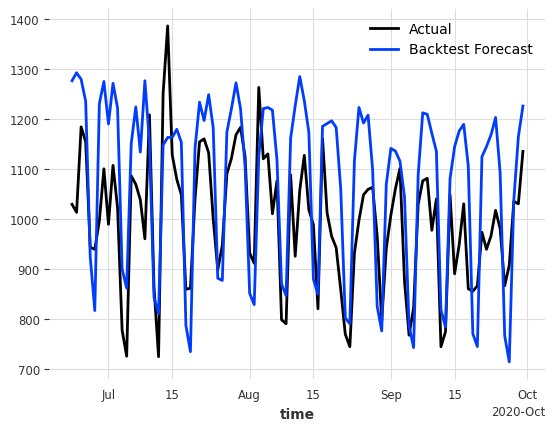

In [22]:
def plot_backtest(ts, backtest, length=100):
    ts[-length:].plot(label="Actual")
    backtest[-length:].plot(label="Backtest Forecast")
    plt.legend()
    plt.show()


plot_backtest(ts, backtest)

In [29]:
def get_queue_data(df, queue_to_all_children, queue_id):
    queues = queue_to_all_children[queue_id]
    df_slice = df[df["queueId"].isin(queues)].groupby("date")[["new_tickets"]].sum()
    return df_slice


def df_to_timeseries(df_slice):
    ts = TimeSeries.from_dataframe(
        df_slice, value_cols="new_tickets", fill_missing_dates=True, freq="D"
    )
    return ts


def generate_past_covariates(df):
    df_total = df.groupby("date")[["new_tickets"]].sum()
    past_covariates = TimeSeries.from_dataframe(
        df_total, value_cols="new_tickets", fill_missing_dates=True, freq="D"
    )
    return past_covariates


def generate_future_covariates(ts, country_code="RU", add_length=None):
    if add_length:
        future_covariates = holidays_timeseries(
            time_index=ts, country_code=country_code, add_length=add_length
        )
    else:
        future_covariates = holidays_timeseries(
            time_index=ts, country_code=country_code
        )
    return future_covariates


def train_model(
    ts,
    past_covariates=None,
    future_covariates=None,
    model_cls=RegressionModel,
    model_kwargs={},
):
    model = model_cls(**model_kwargs)
    model.fit(ts, past_covariates=past_covariates, future_covariates=future_covariates)
    return model


def backtest_model(
    model,
    ts,
    past_covariates=None,
    future_covariates=None,
    start=0.8,
    forecast_horizon=10,
):
    backtest = model.historical_forecasts(
        series=ts,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=start,
        retrain=False,
        verbose=True,
        forecast_horizon=forecast_horizon,
    )
    actual_series = ts.slice_intersect(backtest)
    error = rmse(actual_series, backtest)
    print(f"Backtest RMSE = {error}")
    return backtest, error


def plot_backtest(ts, backtest, length=100):
    ts[-length:].plot(label="Actual")
    backtest[-length:].plot(label="Backtest Forecast")
    plt.legend()
    plt.show()


def eval_model(
    model,
    ts,
    past_covariates=None,
    future_covariates=None,
    start=0.8,
    forecast_horizon=10,
):
    backtest, error = backtest_model(
        model,
        ts,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=start,
        forecast_horizon=forecast_horizon,
    )
    plot_backtest(ts, backtest)
    return backtest, error


def predict_future(model, n_predict, past_covariates=None, future_covariates=None):
    prediction = model.predict(
        n=n_predict,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
    )
    return prediction


def predict_new_tickets(
    df,
    queue_to_all_children,
    queue_id,
    n_predict=10,
    model_cls=RegressionModel,
    model_kwargs={},
    country_code="RU",
):
    df_slice = get_queue_data(df, queue_to_all_children, queue_id)
    ts = df_to_timeseries(df_slice)

    past_covariates = generate_past_covariates(df)
    future_covariates = generate_future_covariates(
        ts,
        country_code=country_code,
        add_length=n_predict,
    )
    model = train_model(
        ts,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        model_cls=model_cls,
        model_kwargs=model_kwargs,
    )

    prediction = model.predict(
        n=n_predict,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
    )
    return prediction

In [35]:
queue_id = 1871

model_kwargs = {
    "lags": 30,
    "lags_past_covariates": list(range(-29, 0)),
    "lags_future_covariates": [0],
}
df_slice = get_queue_data(df, queue_to_all_children, queue_id)
ts = df_to_timeseries(df_slice)
n_predict = 60
model = LinearRegressionModel(lags=30)
eval_model(model, ts)

ValueError: The model has not been fitted yet, and `retrain` is ``False``. Either call `fit()` before `historical_forecasts()`, or set `retrain` to something different than ``False``.


ValueError: The model has not been fitted yet, and `retrain` is ``False``. Either call `fit()` before `historical_forecasts()`, or set `retrain` to something different than ``False``.

In [36]:
prediction = predict_new_tickets(
    df,
    queue_to_all_children,
    queue_id,
    n_predict=n_predict,
    model_cls=RegressionModel,
    model_kwargs=model_kwargs,
    country_code="RU",
)

prediction.plot(label="Prediction")
plt.legend()
plt.show()

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
ValueError: The `past_covariates` are not long enough. Given horizon `n=60`, `min(lags_past_covariates)=-29`, `max(lags_past_covariates)=-1` and `output_chunk_length=1`, the `past_covariates` have to range from 2020-09-02 00:00:00 until 2020-11-28 00:00:00 (inclusive), but they only range from 2017-01-01 00:00:00 until 2020-09-30 00:00:00.


ValueError: The `past_covariates` are not long enough. Given horizon `n=60`, `min(lags_past_covariates)=-29`, `max(lags_past_covariates)=-1` and `output_chunk_length=1`, the `past_covariates` have to range from 2020-09-02 00:00:00 until 2020-11-28 00:00:00 (inclusive), but they only range from 2017-01-01 00:00:00 until 2020-09-30 00:00:00.

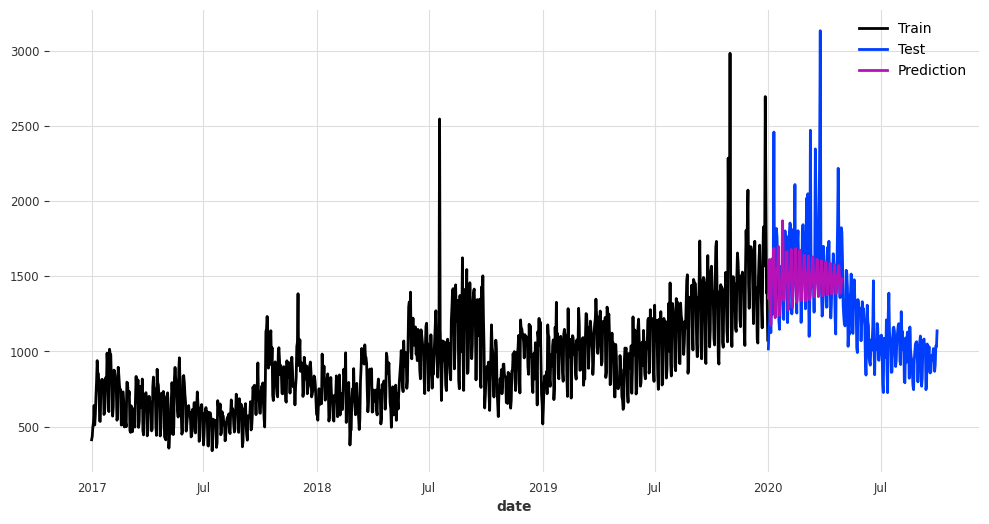

In [149]:
# queue_id = 1871
# df_slice = get_queue_data(df, queue_to_all_children, queue_id)
# ts = df_to_timeseries(df_slice)

# model, train, test, prediction = train_and_predict(ts, n_predict=120)

# plot_results(train, test, prediction)

# top_10_queue_ids = top_queues
# scores = get_top_queues_scores(df, queue_to_all_children, top_10_queue_ids)

# future_prediction = predict_new_tickets(
#     df, queue_to_all_children, queue_id, n_predict=60
# )

In [ ]:
from darts import TimeSeries
from darts.models import RegressionModel
from darts.metrics import rmse
from darts.utils.timeseries_generation import holidays_timeseries
import matplotlib.pyplot as plt


def get_queue_data(df, queue_to_all_children, queue_id):
    queues = queue_to_all_children[queue_id]
    return df[df["queueId"].isin(queues)].groupby("date")[["new_tickets"]].sum()


def df_to_timeseries(df_slice):
    return TimeSeries.from_dataframe(
        df_slice, value_cols="new_tickets", fill_missing_dates=True, freq="D"
    )


def generate_past_covariates(df):
    df_total = df.groupby("date")[["new_tickets"]].sum()
    return TimeSeries.from_dataframe(
        df_total, value_cols="new_tickets", fill_missing_dates=True, freq="D"
    )


def generate_future_covariates(ts, country_code="RU", add_length=None):
    return holidays_timeseries(
        time_index=ts, country_code=country_code, add_length=add_length
    )


def train_model(ts, model_cls=RegressionModel, model_kwargs={}, **covariates):
    model = model_cls(**model_kwargs)
    model.fit(ts, **covariates)
    return model


def backtest_model(model, ts, start=0.8, forecast_horizon=10, **covariates):
    backtest = model.historical_forecasts(
        series=ts,
        start=start,
        retrain=False,
        verbose=True,
        forecast_horizon=forecast_horizon,
        **covariates,
    )
    error = rmse(ts.slice_intersect(backtest), backtest)
    print(f"Backtest RMSE = {error}")
    return backtest, error


def plot_backtest(ts, backtest, length=100):
    ts[-length:].plot(label="Actual")
    backtest[-length:].plot(label="Backtest Forecast")
    plt.legend()
    plt.show()


def eval_model(
    ts,
    model_cls=RegressionModel,
    model_kwargs={},
    start=0.8,
    forecast_horizon=10,
    **covariates,
):
    model = train_model(
        ts, model_cls=model_cls, model_kwargs=model_kwargs, **covariates
    )
    backtest, error = backtest_model(
        model, ts, start=start, forecast_horizon=forecast_horizon, **covariates
    )
    plot_backtest(ts, backtest)
    return backtest, error


def predict_future(model, n_predict, **covariates):
    return model.predict(n=n_predict, **covariates)


def predict_new_tickets(
    df,
    queue_to_all_children,
    queue_id,
    n_predict=10,
    model_cls=RegressionModel,
    model_kwargs={},
    country_code="RU",
):
    df_slice = get_queue_data(df, queue_to_all_children, queue_id)
    ts = df_to_timeseries(df_slice)
    past_covariates = generate_past_covariates(df)
    future_covariates = generate_future_covariates(
        ts, country_code=country_code, add_length=n_predict
    )

    model = train_model(
        ts,
        model_cls=model_cls,
        model_kwargs=model_kwargs,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
    )
    prediction = predict_future(
        model,
        n_predict,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
    )

    prediction.plot(label="Prediction")
    plt.legend()
    plt.show()
    return prediction


In [37]:
predict_new_tickets(df, queue_to_all_children, queue_id)

ValueError: At least one of `lags`, `lags_future_covariates` or `lags_past_covariates` must be not None.


ValueError: At least one of `lags`, `lags_future_covariates` or `lags_past_covariates` must be not None.

In [ ]:
# darts.utils.timeseries_generation.holidays_timeseries

In [ ]:
flow_train, _ = flow.split_before(0.8)


def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests

    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(
        series=flow,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=0.8,
        retrain=False,
        verbose=True,
        forecast_horizon=10,
    )

    flow[-len(backtest) - 100 :].plot()
    backtest.plot(label="backtest (n=10)")
    print("Backtest RMSE = {}".format(rmse(flow, backtest)))

In [153]:
ts.add_holidays("RU")

<TimeSeries (DataArray) (date: 1369, component: 2, sample: 1)> Size: 22kB
array([[[4.120e+02],
        [1.000e+00]],

       [[4.340e+02],
        [1.000e+00]],

       [[4.960e+02],
        [1.000e+00]],

       ...,

       [[1.036e+03],
        [0.000e+00]],

       [[1.031e+03],
        [0.000e+00]],

       [[1.136e+03],
        [0.000e+00]]])
Coordinates:
  * date       (date) datetime64[ns] 11kB 2017-01-01 2017-01-02 ... 2020-09-30
  * component  (component) object 16B 'new_tickets' 'holidays'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [150]:
scores

{742: 35.85354820838302,
 1871: 28.822069909364107,
 115: 26.996708884392703,
 4447: 37.44067379019783,
 2641: 41.91344090166164,
 2002: 25.289697722551605,
 10: 23.91855098987389,
 4412: 42.623222805147094,
 34: 30.845904034196394,
 2610: 30.80863606127136}

In [105]:
df.date.describe()

count                           418327
mean     2019-03-01 08:31:49.778714368
min                2017-01-01 00:00:00
25%                2018-04-20 00:00:00
50%                2019-04-25 00:00:00
75%                2020-02-04 00:00:00
max                2020-09-30 00:00:00
Name: date, dtype: object

<Axes: xlabel='date'>

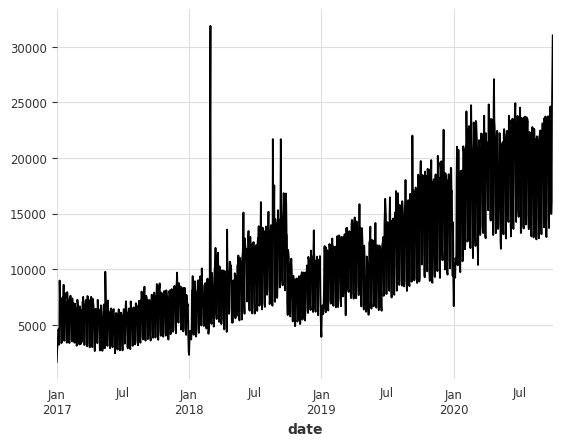

In [113]:
df.groupby("date").sum("new_tickets")["new_tickets"].plot()

In [82]:
df.head()

,queueId,date,new_tickets
0,1,2017-01-01,15
1,1,2017-01-02,26
2,1,2017-01-03,25
3,1,2017-01-04,29
4,1,2017-01-05,26


## use all queues and use hierarchy (WIP)

In [83]:
df_wide = df.pivot(index="date", columns="queueId", values="new_tickets")
df_wide = df_wide.reset_index()

In [84]:
df_wide.head()

queueId,date,1,7,9,10,13,14,18,25,26,...,101339,101340,101341,101343,101344,101349,101350,101351,101352,101359
0,2017-01-01,15.0,8.0,2.0,16.0,28.0,1.0,13.0,106.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,26.0,23.0,NaN,23.0,24.0,2.0,16.0,140.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-03,25.0,23.0,NaN,28.0,22.0,4.0,20.0,140.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-04,29.0,20.0,2.0,25.0,33.0,7.0,12.0,175.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-05,26.0,27.0,NaN,28.0,22.0,5.0,11.0,137.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
df_wide.shape

(1369, 829)

In [86]:
df_wide = df_wide.fillna(0)

In [87]:
series = TimeSeries.from_dataframe(df_wide, "date", fill_missing_dates=True, freq="D")

In [88]:
len(series)

1369

In [99]:
n_val = 100
train, val = series[:-n_val], series[-n_val:]

In [101]:
len(train), len(val)

(1269, 100)

In [102]:
preds = []
for component in series.components:
    model = LinearRegressionModel(lags=100)
    model.fit(train[component])
    preds.append(model.predict(n=len(val)))

pred = concatenate(preds, axis="component")

In [103]:
pred

<TimeSeries (DataArray) (date: 100, component: 828, sample: 1)> Size: 662kB
array([[[1.75738442e+02],
        [8.14410583e+01],
        [8.20393274e-03],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.63577858e+02],
        [7.99662316e+01],
        [8.09696134e-02],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.71662427e+02],
        [8.10634459e+01],
        [9.22956561e-03],
        ...,
...
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.21041612e+02],
        [7.85678737e+01],
        [2.41874389e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.29281620e+02],
        [7.81881589e+01],
        [2.28996892e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * date       (date) datetime64[ns] 800B 2020-06-23 2020-06-24 ... 2020-09-30
  * component  (component) object 7kB '1' '7' '9' ... '101351' '101352' '101359'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [67]:
model = LinearRegressionModel(lags=12)
model.fit(train)
pred = model.predict(n=len(val))

In [70]:
series.components

Index(['1', '7', '9', '10', '13', '14', '18', '25', '26', '29',
       ...
       '101339', '101340', '101341', '101343', '101344', '101349', '101350',
       '101351', '101352', '101359'],
      dtype='object', name='component', length=828)

<Axes: xlabel='date'>

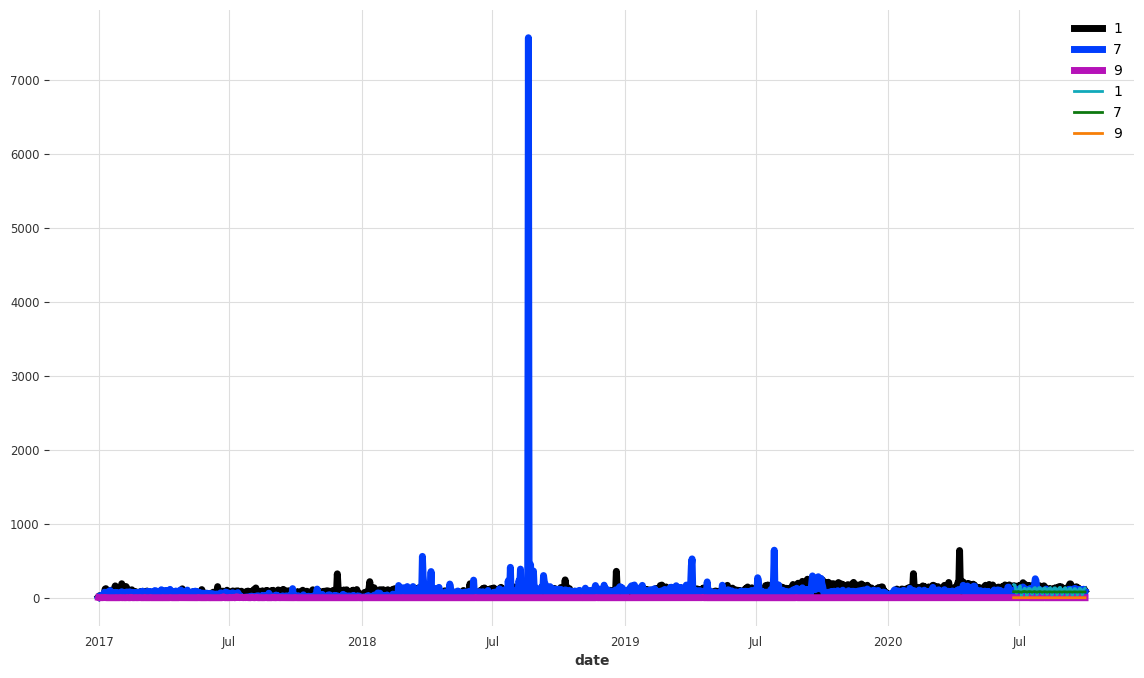

In [104]:
plt.figure(figsize=(14, 8))
components_to_show = ["1", "7", "9"]
series[components_to_show].plot(lw=5)
pred[components_to_show].plot(lw=2)

In [ ]:
def measure_mae(pred):
    def print_mae_on_subset(subset, name):
        print(
            "mean MAE on {}: {:.2f}".format(
                name,
                mae(pred[subset], val[subset]),
            )
        )

    print_mae_on_subset(["Total"], "total")
    print_mae_on_subset(reasons, "reasons")
    print_mae_on_subset(regions, "regions")
    print_mae_on_subset(regions_reasons_comps, "(region, reason)")
    print_mae_on_subset(regions_reasons_city_comps, "(region, reason, city)")

In [ ]:
measure_mae(pred)